**Can a player's age and total hours played predict whether they subscribe to a game-related newsletter?**

**Introduction:**
Video games generate rich behavioural data, offering insights not only into player engagement but also into broader patterns of human-computer interaction. As gaming platforms grow in complexity, understanding user behaviour becomes increasingly valuable for server planning, targeted communication, and improving player experience. In particular, predicting which players are likely to subscribe to a game's newsletter can help game developers and researchers direct outreach efforts and resource allocation.

In this project, we analyze player behaviour data collected from a Minecraft research server maintained by a computer science group at the University of British Columbia (UBC). The server tracks users' individual play sessions, allowing us to aggregate behavioural features for each player. The project’s goal is to explore whether these behavioural patterns can be used to predict which players are most likely to subscribe to a game-related newsletter. The guiding question for the project is:
**Can a player's age and total hours played predict whether they subscribe to a game-related newsletter?** 

To analyze this, we will be looking at a dataset that includes the following columns:

* `experience`: the player's self-reported experience level with Minecraft. It reflects how familiar or skilled they consider themselves to be (beginner, amateur, regular, veteran, pro)
* `subscribe`: shows whether the player subscribed to a game-related newsletter
* `hashedEmail`: represents an anonymized unique identifier for each player
* `played_hours`: the amount of hours of the game played by the player
* `name`: the name of the player
* `gender`: the gender of the player (male/female)
* `age`: the age of the player

To begin the analysis, it is necessary to load the R packages that will be used for the analysis. Classification and using KNN would a good choice for the analysis because my response variable is categorical.

In [4]:
library(tidyverse)
library(tidymodels)
library(tidyclust)
library(forcats)
library(repr)
library(themis)

options(repr.matrix.max.rows = 6)

Then, I read in the players.csv data using read_csv() and assigned it to an object called players. 

In [5]:
players <- read_csv("data/players.csv")

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [6]:
players

experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
⋮,⋮,⋮,⋮,⋮,⋮,⋮
Amateur,FALSE,d572f391d452b76ea2d7e5e53a3d38bfd7499c7399db299bd4fedb06a46ad5bb,0.0,Dylan,Prefer not to say,17
Amateur,FALSE,f19e136ddde68f365afc860c725ccff54307dedd13968e896a9f890c40aea436,2.3,Harlow,Male,17
Pro,TRUE,d9473710057f7d42f36570f0be83817a4eea614029ff90cf50d8889cdd729d11,0.2,Ahmed,Other,NA


However, we will only be working with these columns:
| Variable Name  | Description                                 | Type                 |
|----------------|---------------------------------------------|----------------------|
| Age            | Age of the player                           | Numeric              |
| played_hours   | Total number of hours the player has played | Numeric              |
| subscribe      | Whether player subscribed to newsletter     | Factor (TRUE/FALSE)  |

I removed the other columns for analysis clarity. I then removed players with missing `age` or `played_hours` data, renamed my columns and changed subscribed into a factor so analysis can be easier. 

In [7]:
players_data <- players |>
    select(played_hours, subscribe, Age) |>
    filter(!is.na(played_hours), !is.na(Age)) |>
    rename(is_subscribed = subscribe, age = Age) |>
    mutate(is_subscribed = as.factor(is_subscribed))

players_data

played_hours,is_subscribed,age
<dbl>,<fct>,<dbl>
30.3,TRUE,9
3.8,TRUE,17
0.0,FALSE,17
⋮,⋮,⋮
0.3,FALSE,22
0.0,FALSE,17
2.3,FALSE,17


I then took this data and split it into a test and training test, using 70% of the data as the training set and then setting subscribe as the strata argument.

In [8]:
set.seed(1234) #so it can be reproduced

players_split <- initial_split(players_data, prop = 0.7, strata = is_subscribed)
players_training <- training(players_split)
players_testing <- testing(players_split)

I wanted to visualize the training data to see if oversampling needed to be done, so I used a scatter plot to plot it.

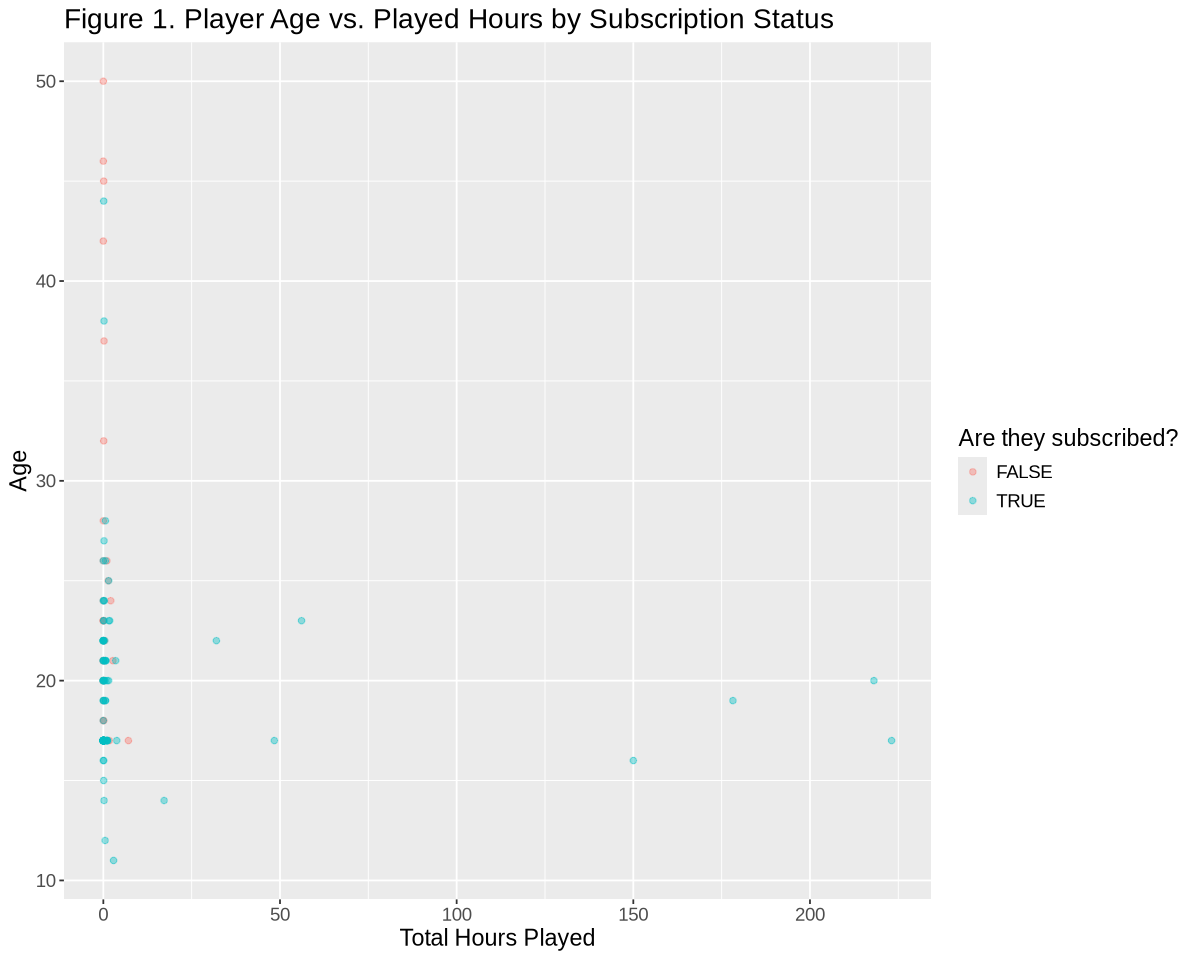

In [19]:
options(repr.plot.width = 10, repr.plot.height = 8)

training_plot <- players_training |>
    ggplot(aes(x = played_hours, y = age, color = is_subscribed)) +
  geom_point(alpha = 0.4) +
  labs( title = "Figure 1. Player Age vs. Played Hours by Subscription Status", 
    x = "Total Hours Played",
    y = "Age",
    color = "Are they subscribed?") +
    theme(text = element_text(size = 14))

training_plot

From initial visualizations, there does not seem to be a trend between age, hours played and subscription status. Regardless, I will continue with my predictions. I also noticed that there were more people who were subscribed than not, so I tested if the number of FALSE and TRUE was balanced. 

In [10]:
counts <- players_training |> 
    group_by(is_subscribed) |> 
    summarize(count=n())

counts

is_subscribed,count
<fct>,<int>
FALSE,36
TRUE,99


There were more FALSE than TRUE classes, so in my recipe, I will oversample FALSE. I applied upsampling in the training set to equalize class frequencies for better model fairness.

In [11]:
set.seed(1234)
players_recipe <- recipe(is_subscribed ~ played_hours + age, data = players_training) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors()) |>
    step_upsample(is_subscribed, over_ratio = 1, skip = TRUE)

I then created a model specification with tuning to complete a 5-fold cross-validation on it in order to find the best $K$ value and combined the recipe, folds and model specification into a workflow analysis to build the classifier. I decided to test $K$ values from 1 to 10 as more $K$ values would be too strenuous on my computer. 

In [12]:
set.seed(1234)
players_tune_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

players_vfold <- vfold_cv(players_training, v = 5, strata = is_subscribed)

players_results <- workflow() |>
    add_recipe(players_recipe) |>
    add_model(players_tune_spec) |>
    tune_grid(resamples = players_vfold, grid = tibble(neighbors = 1:10)) |>
    collect_metrics()

Then, I found the best $K$ value. To do this, from players_results, I filtered for accuracy from the .metric column. Then, I created a line plot using the accuracy dataset with neighbours on the x-axis and the mean on the y-axis.

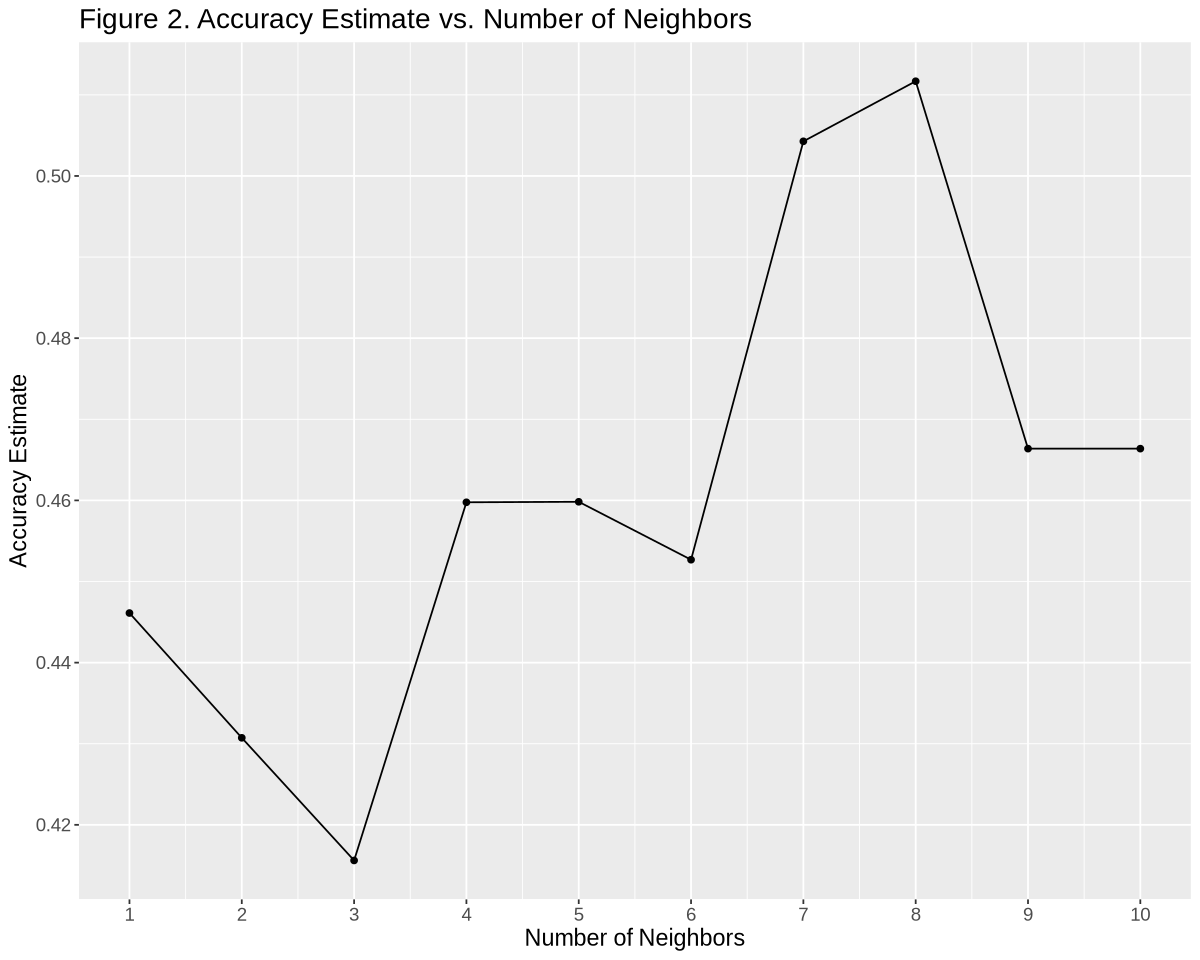

In [21]:
set.seed(1234)
accuracies <- players_results |> 
      filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
      geom_point() +
      geom_line() +
      labs(title = "Figure 2. Accuracy Estimate vs. Number of Neighbors", x = "Number of Neighbors", y = "Accuracy Estimate") +
      scale_x_continuous(breaks = seq(0, 14, by = 1)) + 
      theme(text = element_text(size = 14))
accuracy_versus_k

From the plot above, it can be seen that using $K$ value of 8 leads to the highest accuracy, but the accuracy estimate is not high leading to possibly many errors when passing the model through the test set. We can be sure that $K= 8$ is good as cross-validation was used to find this value. I will first build my model specification with $K$ value. Then, I passed the model specification and the training dataset to the fit() function. Because KNN uses distance calculations, it also assumes that all predictor variables are numeric and on a similar scale. We addressed this by centring and scaling the data during preprocessing. The model also required that there be no missing values, which I removed through data cleaning. Finally, selecting an appropriate $K$ was critical so cross validation was used to choose the best one. 

In [14]:
players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 8) |>
       set_engine("kknn") |>
       set_mode("classification")

players_fit <- workflow() |>
             add_recipe(players_recipe) |>
             add_model(players_spec) |>
            fit(data = players_training)

I used my final model to predict on the test dataset, then reported the accuracy of this prediction, and store this in an object named mnist_metrics. Then, I created a confusion matrix to evaluate the precision and recall of the classifier.

In [15]:
players_predictions <- predict(players_fit, players_testing) |>
                        bind_cols(players_testing)

players_metrics <- players_predictions |> metrics(truth = is_subscribed, estimate = .pred_class)

players_conf_mat <- players_predictions |>
                        conf_mat(truth = is_subscribed, estimate = .pred_class) 
players_metrics
players_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.37288136
kap,binary,0.03705337


          Truth
Prediction FALSE TRUE
     FALSE    14   35
     TRUE      2    8

From the results of above, it seems as if model accuracy is 37% and kappa is 0.037 indicating a poorly performing model.

**Discussion**
The goal of this project was to predict whether a player would subscribe to a game-related newsletter based on their age and total hours played. Using a K-nearest neighbours classification approach, it was found that the best-performing model with $K = 8 $achieved an accuracy of approximately 37%, with a Kappa score of ~0.037, indicating that the model performed only slightly better than random guessing. 

This result was not what I expected. Intuitively, one might assume that players who spend more time in-game or people in specific age groups (teens/young adults) may be more likely to subscribe to game-related content. However, the lack of predictive power suggests that **neither age nor total playtime are strong indicators of subscription behaviour on its own**. Other factors, such as player engagement style, in-game achievements, or external motivations could play a more significant role.

The impact of these findings suggests that basic gameplay metrics may not be sufficient to predict engagement behaviours like newsletter subscription. For game developers or marketing teams, this implies that targeting strategies based solely on playtime or demographic info may not be effective.

This leads to several future questions:

- Would including other variables like player experience level, session frequency, or gender improve predictive power?

- Could more complex models yield better performance?

- Are there qualitative factors (like player satisfaction or community involvement) that influence subscription behaviour more than quantitative ones?

Ultimately, this project highlights the challenges of behavioural prediction and the importance of incorporating richer and more diverse data to understand player engagement.
